# Data Exploration & Cleaning

**Purpose:** Load, clean, and explore the customer churn dataset.

**Input:** `data/raw/telco_customer_churn.csv`  
**Outputs:** Cleaned CSV, SQLite database, visualizations

**Note:** This took about 3 hours initially to figure out the data quality issues, especially the TotalCharges field having spaces instead of numbers for new customers.

In [2]:
# Environment Setup & Library Imports

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)
sns.set_style('whitegrid')

RANDOM_STATE = 42

# Note: Spent way too long debugging Windows path issues before 
# discovering pathlib.Path handles cross-platform paths automatically

# Define file paths
DATA_RAW = Path('..') / 'data' / 'raw' / 'telco_customer_churn.csv'
DATA_PROCESSED = Path('..') / 'data' / 'processed'
FIG_OUT = Path('..') / 'outputs' / 'figures'

# Create output directories if they don't exist
FIG_OUT.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

print('✓ Environment configured successfully')
print('\n📁 File Paths:')
print(f'  INPUT  → {DATA_RAW.absolute()}')
print(f'  OUTPUT → {DATA_PROCESSED.absolute()}')
print(f'  FIGURES→ {FIG_OUT.absolute()}')
print('\n' + '='*80)

✓ Environment configured successfully

📁 File Paths:
  INPUT  → c:\Users\Tuf\Desktop\New folder\Projects\Customer Churn Prediction & Analysis\github_public\notebooks\..\data\raw\telco_customer_churn.csv
  OUTPUT → c:\Users\Tuf\Desktop\New folder\Projects\Customer Churn Prediction & Analysis\github_public\notebooks\..\data\processed
  FIGURES→ c:\Users\Tuf\Desktop\New folder\Projects\Customer Churn Prediction & Analysis\github_public\notebooks\..\outputs\figures



In [1]:
# ============================================================================
# CELL 0: ENVIRONMENT AUTO-DETECTION (Local vs Google Colab)
# ============================================================================
#
# PURPOSE:
# --------
# Automatically detect execution environment and configure paths accordingly.
# This makes the notebook portable between local Python and Google Colab.
#
# DETECTION LOGIC:
# ----------------
# - Check for 'google.colab' module (only exists in Colab)
# - If Colab: Mount Google Drive and use Drive paths
# - If Local: Use relative paths from notebook location
#
# WHY THIS MATTERS:
# -----------------
# Single notebook works in both environments without manual path changes!
#
# ============================================================================

import sys
import os

# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print('🌐 ENVIRONMENT: Google Colab detected')
except ImportError:
    IN_COLAB = False
    print('💻 ENVIRONMENT: Local Python detected')

# Configure paths based on environment
if IN_COLAB:
    print('\n📁 Setting up Google Colab environment...')
    
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    
    # Prompt user for project path in Google Drive
    print('\n⚠️  IMPORTANT: Update this path to your project location in Google Drive!')
    print('    Example: /content/drive/MyDrive/Projects/Customer Churn Prediction & Analysis')
    
    # Default path (user should modify this)
    PROJECT_ROOT = '/content/drive/MyDrive/Customer Churn Prediction & Analysis'
    
    # Change to project directory
    os.chdir(PROJECT_ROOT)
    print(f'✓ Changed directory to: {PROJECT_ROOT}')
    
    # Install required packages (if not already installed)
    print('\n📦 Installing required packages...')
    !pip install -q pandas numpy matplotlib seaborn scikit-learn joblib
    print('✓ Packages installed')
    
else:
    # Local environment - paths relative to notebook location
    print('✓ Using local file system paths')
    PROJECT_ROOT = os.path.abspath('..')
    print(f'  Project root: {PROJECT_ROOT}')

print('\n' + '='*80)
print('✓ Environment configuration complete!')
print('='*80 + '\n')

💻 ENVIRONMENT: Local Python detected
✓ Using local file system paths
  Project root: c:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis

✓ Environment configuration complete!



In [3]:
# ============================================================================
# CELL 2: LOAD RAW DATA
# ============================================================================
#
# PURPOSE:
# --------
# Load the raw customer churn CSV file into a pandas DataFrame.
#
# WHAT IS A DATAFRAME?
# --------------------
# Think of it as an Excel spreadsheet in Python:
# - Rows = Individual customers (observations)
# - Columns = Customer attributes (variables/features)
# - Index = Row numbers (0, 1, 2, ...)
#
# ERROR HANDLING:
# ---------------
# We use try/except to gracefully handle missing files:
# - try: Attempt to read CSV
# - except FileNotFoundError: If file doesn't exist, create empty DataFrame
#   and show helpful error message
#
# WHY THIS MATTERS:
# -----------------
# If data file is missing, rest of notebook won't crash - it will just skip
# cells that require data. This is defensive programming!
#
# ============================================================================

try:
    # pd.read_csv() reads CSV file into DataFrame
    df_raw = pd.read_csv(DATA_RAW)
    print('✓ Successfully loaded raw CSV file')
    print(f'  File: {DATA_RAW.name}')
    
except FileNotFoundError:
    # Friendly error message if file is missing
    print(f'✗ ERROR: File not found at {DATA_RAW}')
    print('\n📌 TROUBLESHOOTING:')
    print('  1. Check that data/raw/ folder exists')
    print('  2. Download dataset from Kaggle:')
    print('     https://www.kaggle.com/datasets/blastchar/telco-customer-churn')
    print('  3. Place telco_customer_churn.csv in data/raw/')
    df_raw = pd.DataFrame()  # Empty DataFrame to prevent errors

# ============================================================================
# QUICK INSPECTION
# ============================================================================
print('\n' + '='*80)
print('DATASET OVERVIEW')
print('='*80)

if not df_raw.empty:
    print(f'📊 Dimensions: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns')
    print(f'💾 Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
    print('\n🔍 First 5 rows preview:')
    display(df_raw.head(5))
else:
    print('⚠ No data loaded (empty DataFrame)')
    
print('='*80)

✓ Successfully loaded raw CSV file
  File: telco_customer_churn.csv

DATASET OVERVIEW
📊 Dimensions: 7,043 rows × 21 columns
💾 Memory usage: 7.79 MB

🔍 First 5 rows preview:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# ============================================================================
# CELL 3: DATA PROFILING & QUALITY ASSESSMENT
# ============================================================================
#
# PURPOSE:
# --------
# Understand data structure, types, and quality issues before analysis.
#
# KEY INSPECTION STEPS:
# ---------------------
# 1. df.head(8) - First 8 rows (spot patterns)
# 2. df.shape - Dimensions (rows × columns)
# 3. df.dtypes - Data types per column (int, float, object/string)
# 4. df.isnull().sum() - Missing value counts
#
# DATA TYPE THEORY:
# -----------------
# - int64: Whole numbers (tenure, SeniorCitizen)
# - float64: Decimals (MonthlyCharges, TotalCharges)
# - object: Strings/text (Contract, PaymentMethod, Churn)
#
# WHY CHECK MISSING VALUES?
# -------------------------
# Missing data can:
# - Bias analysis results
# - Cause model training errors
# - Represent real business issues (e.g., data collection failures)
#
# EXPECTED DATA QUALITY ISSUES:
# -----------------------------
# - TotalCharges: Some blank values (new customers with tenure=0)
# - These need cleaning before analysis
#
# ============================================================================

if not df_raw.empty:
    print('='*80)
    print('DATA STRUCTURE INSPECTION')
    print('='*80)
    
    # Display first 8 rows to spot patterns
    print('\n📋 Sample Data (First 8 Rows):')
    display(df_raw.head(8))
    
    # Show dimensions
    rows, cols = df_raw.shape
    print(f'\n📐 Dataset Shape:')
    print(f'  Rows (Customers): {rows:,}')
    print(f'  Columns (Features): {cols}')
    
    # Show data types - critical for understanding what operations are valid
    print(f'\n🏷️  Data Types:')
    print('  (object = text/string, int64 = integer, float64 = decimal)')
    display(df_raw.dtypes.to_frame(name='dtype'))
    
    # Missing value analysis
    print(f'\n⚠️  Missing Values Analysis:')
    missing = df_raw.isnull().sum()
    missing_pct = (100 * missing / len(df_raw)).round(2)
    missing_summary = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Percent': missing_pct
    }).query('Missing_Count > 0')  # Only show columns with missing values
    
    if len(missing_summary) > 0:
        display(missing_summary)
        print(f'\n⚠ Found {len(missing_summary)} columns with missing data')
    else:
        print('  ✓ No missing values detected!')
    
    print('='*80)
else:
    print('⚠ No data loaded - cannot perform inspection')

DATA STRUCTURE INSPECTION

📋 Sample Data (First 8 Rows):


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No



📐 Dataset Shape:
  Rows (Customers): 7,043
  Columns (Features): 21

🏷️  Data Types:
  (object = text/string, int64 = integer, float64 = decimal)


,dtype
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object



⚠️  Missing Values Analysis:
  ✓ No missing values detected!


In [5]:
# ============================================================================
# CELL 4: DATA CLEANING & NORMALIZATION
# ============================================================================
#
# PURPOSE:
# --------
# Transform raw data into analysis-ready format through systematic cleaning.
#
# CLEANING OPERATIONS EXPLAINED:
# -------------------------------
#
# 1️⃣ STRIP WHITESPACE
#    Problem: "Yes " != "Yes" (trailing space breaks grouping)
#    Solution: .str.strip() removes leading/trailing spaces
#    Impact: Ensures consistent string matching in SQL queries
#
# 2️⃣ CONVERT TOTALCHARGES TO NUMERIC
#    Problem: Column is stored as 'object' (text) instead of numbers
#    Reason: Some cells contain blank spaces instead of values
#    Solution: pd.to_numeric(errors='coerce') - convert or set to NaN
#    Theory: Can't calculate mean/sum of text values!
#
# 3️⃣ CONVERT TENURE TO INTEGER
#    Problem: tenure might have decimals or missing values
#    Solution: Convert to numeric, fill missing with 0, cast to int
#    Why: Tenure represents whole months (3 months, not 3.5 months)
#
# 4️⃣ NORMALIZE YES/NO TO 1/0 (MOST IMPORTANT!)
#    Problem: SQL and ML models work better with numeric binary values
#    Columns affected: Partner, Dependents, PhoneService, PaperlessBilling, Churn
#    
#    Before:  "Yes" / "No" (text)
#    After:   1 / 0 (numeric binary)
#    
#    WHY THIS MATTERS:
#    -----------------
#    - SQL: SUM(Churn) works with 1/0, but SUM('Yes') doesn't
#    - ML: Algorithms need numeric inputs
#    - Analysis: AVG(Churn) = churn rate (26.5% = 0.265)
#    
#    Example:
#    --------
#    Original SQL: SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END)  ❌ Complex
#    Clean SQL:    SUM(Churn)                                     ✅ Simple
#
# DEFENSIVE PROGRAMMING:
# ----------------------
# - df.copy(): Work on copy to preserve original data
# - 'if col in df.columns': Only process columns that exist
# - errors='coerce': Don't crash on bad data, convert to NaN instead
#
# ============================================================================

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and normalize the customer churn dataset.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Raw dataframe from CSV
    
    Returns:
    --------
    pd.DataFrame
        Cleaned dataframe with normalized values
    
    Cleaning Steps:
    ---------------
    1. Strip whitespace from string columns
    2. Convert TotalCharges to numeric (handle blank values)
    3. Convert tenure to integer
    4. Normalize Yes/No → 1/0 for binary columns
    """
    # Create copy to avoid modifying original data
    df = df.copy()
    
    # Step 1: Strip whitespace from all text columns
    obj_cols = df.select_dtypes(['object']).columns
    print(f'🧹 Cleaning {len(obj_cols)} text columns...')
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip()
    
    # Step 2: Convert TotalCharges to numeric
    # Some rows have blank spaces (" ") instead of numbers
    if 'TotalCharges' in df.columns:
        print('💰 Converting TotalCharges to numeric...')
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        # errors='coerce' means: if conversion fails, set to NaN (not a number)
    
    # Step 3: Convert tenure to integer
    if 'tenure' in df.columns:
        print('📅 Converting tenure to integer...')
        df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce').fillna(0).astype(int)
    
    # Step 4: Normalize Yes/No to 1/0 (CRITICAL FOR SQL QUERIES!)
    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
    print(f'🔄 Normalizing {len(binary_cols)} binary columns (Yes/No → 1/0)...')
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].replace({'Yes': 1, 'No': 0})
            # This enables: SUM(Churn) instead of SUM(CASE WHEN Churn='Yes'...)
    
    return df

# ============================================================================
# EXECUTE CLEANING PROCESS
# ============================================================================

if not df_raw.empty:
    print('='*80)
    print('DATA CLEANING PROCESS')
    print('='*80)
    print()
    
    # Run cleaning function
    df = clean_data(df_raw)
    
    print()
    print(f'✓ Cleaning complete!')
    print(f'  Shape: {df.shape}')
    print(f'\n📊 Cleaned Data Preview (First 3 Rows):')
    display(df.head(3))
    
    # Verify Yes/No conversion
    print('\n🔍 Verification - Binary Columns (should show 0/1, not Yes/No):')
    print(df[['Partner', 'Dependents', 'Churn']].head(3))
    
    print('='*80)
else:
    df = pd.DataFrame()
    print('⚠ No data to clean (df_raw is empty)')

DATA CLEANING PROCESS

🧹 Cleaning 18 text columns...
💰 Converting TotalCharges to numeric...
📅 Converting tenure to integer...
🔄 Normalizing 5 binary columns (Yes/No → 1/0)...

✓ Cleaning complete!
  Shape: (7043, 21)

📊 Cleaned Data Preview (First 3 Rows):


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1



🔍 Verification - Binary Columns (should show 0/1, not Yes/No):
   Partner  Dependents  Churn
0        1           0      0
1        0           0      0
2        0           0      1


## Data Cleaning Validation

Verify cleaning process and check data quality.

In [6]:
# ============================================================================
# CELL: DATA CLEANING VALIDATION REPORT
# ============================================================================
#
# PURPOSE:
# --------
# Generate comprehensive validation report comparing before/after cleaning.
# Verify all transformations met expected criteria.
#
# VALIDATION CHECKS:
# ------------------
# 1. Data type conversions (object → int/float where appropriate)
# 2. Binary encoding (Yes/No → 1/0)
# 3. Missing value handling
# 4. Data integrity (no corrupted values)
#
# ============================================================================

if not df.empty and not df_raw.empty:
    print('='*80)
    print('DATA CLEANING VALIDATION REPORT')
    print('='*80)
    
    # ========================================================================
    # CHECK 1: Data Type Transformations
    # ========================================================================
    print('\n✓ CHECK 1: Data Type Conversions')
    print('-' * 80)
    
    # Compare data types before/after
    dtype_comparison = pd.DataFrame({
        'Column': df.columns,
        'Before_Cleaning': [df_raw[col].dtype if col in df_raw.columns else 'N/A' for col in df.columns],
        'After_Cleaning': [df[col].dtype for col in df.columns],
        'Changed': ['✓' if (col in df_raw.columns and df_raw[col].dtype != df[col].dtype) else '' 
                    for col in df.columns]
    })
    
    # Show only changed columns
    changed_dtypes = dtype_comparison[dtype_comparison['Changed'] == '✓']
    if len(changed_dtypes) > 0:
        print(f'\n📊 {len(changed_dtypes)} columns had data type changes:')
        display(changed_dtypes)
    else:
        print('  ⚠️  No data type changes detected')
    
    # ========================================================================
    # CHECK 2: Binary Column Encoding Verification
    # ========================================================================
    print('\n' + '='*80)
    print('✓ CHECK 2: Binary Column Encoding (Yes/No → 1/0)')
    print('-' * 80)
    
    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
    binary_validation = []
    
    for col in binary_cols:
        if col in df.columns:
            unique_vals = sorted(df[col].dropna().unique())
            expected = [0, 1]
            is_valid = list(unique_vals) == expected
            
            binary_validation.append({
                'Column': col,
                'Unique_Values': str(unique_vals),
                'Expected': str(expected),
                'Status': '✓ PASS' if is_valid else '✗ FAIL'
            })
    
    binary_df = pd.DataFrame(binary_validation)
    display(binary_df)
    
    passed = (binary_df['Status'] == '✓ PASS').sum()
    total = len(binary_df)
    print(f'\n📊 Binary Encoding: {passed}/{total} columns passed validation')
    
    # ========================================================================
    # CHECK 3: Numeric Column Validation
    # ========================================================================
    print('\n' + '='*80)
    print('✓ CHECK 3: Numeric Column Validation')
    print('-' * 80)
    
    numeric_checks = []
    
    # Check TotalCharges
    if 'TotalCharges' in df.columns:
        is_numeric = pd.api.types.is_numeric_dtype(df['TotalCharges'])
        has_no_strings = df['TotalCharges'].apply(lambda x: isinstance(x, (int, float, np.number)) or pd.isna(x)).all()
        
        numeric_checks.append({
            'Column': 'TotalCharges',
            'Is_Numeric_Type': '✓' if is_numeric else '✗',
            'No_String_Values': '✓' if has_no_strings else '✗',
            'Min_Value': f"${df['TotalCharges'].min():.2f}" if is_numeric else 'N/A',
            'Max_Value': f"${df['TotalCharges'].max():.2f}" if is_numeric else 'N/A'
        })
    
    # Check tenure
    if 'tenure' in df.columns:
        is_int = pd.api.types.is_integer_dtype(df['tenure'])
        no_decimals = (df['tenure'] % 1 == 0).all()
        
        numeric_checks.append({
            'Column': 'tenure',
            'Is_Numeric_Type': '✓' if is_int else '✗',
            'No_String_Values': '✓' if no_decimals else '✗',
            'Min_Value': f"{df['tenure'].min()} months",
            'Max_Value': f"{df['tenure'].max()} months"
        })
    
    # Check MonthlyCharges
    if 'MonthlyCharges' in df.columns:
        is_numeric = pd.api.types.is_numeric_dtype(df['MonthlyCharges'])
        
        numeric_checks.append({
            'Column': 'MonthlyCharges',
            'Is_Numeric_Type': '✓' if is_numeric else '✗',
            'No_String_Values': '✓',
            'Min_Value': f"${df['MonthlyCharges'].min():.2f}",
            'Max_Value': f"${df['MonthlyCharges'].max():.2f}"
        })
    
    numeric_df = pd.DataFrame(numeric_checks)
    display(numeric_df)
    
    # ========================================================================
    # CHECK 4: Missing Value Summary
    # ========================================================================
    print('\n' + '='*80)
    print('✓ CHECK 4: Missing Value Analysis')
    print('-' * 80)
    
    missing_summary = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum().values,
        'Missing_Percent': (100 * df.isnull().sum() / len(df)).round(2).values
    })
    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing_summary) > 0:
        print(f'\n⚠️  Found {len(missing_summary)} columns with missing values:')
        display(missing_summary)
    else:
        print('\n✓ No missing values detected - excellent data quality!')
    
    # ========================================================================
    # CHECK 5: Data Quality Score
    # ========================================================================
    print('\n' + '='*80)
    print('✓ CHECK 5: Overall Data Quality Score')
    print('-' * 80)
    
    # Calculate quality metrics
    completeness = 100 * (1 - df.isnull().sum().sum() / (len(df) * len(df.columns)))
    type_correctness = 100 * (passed / total) if total > 0 else 100
    row_retention = 100 * (len(df) / len(df_raw)) if len(df_raw) > 0 else 100
    
    quality_score = (completeness + type_correctness + row_retention) / 3
    
    quality_metrics = pd.DataFrame({
        'Metric': ['Data Completeness', 'Type Correctness', 'Row Retention', 'Overall Quality Score'],
        'Score': [f'{completeness:.2f}%', f'{type_correctness:.2f}%', 
                  f'{row_retention:.2f}%', f'{quality_score:.2f}%'],
        'Status': [
            '✓ Excellent' if completeness >= 95 else '⚠️ Needs Attention',
            '✓ Excellent' if type_correctness == 100 else '⚠️ Needs Attention',
            '✓ Excellent' if row_retention >= 95 else '⚠️ Needs Attention',
            '✓ Excellent' if quality_score >= 95 else ('⚠️ Good' if quality_score >= 85 else '✗ Poor')
        ]
    })
    
    display(quality_metrics)
    
    print('\n' + '='*80)
    print('✓ VALIDATION COMPLETE')
    print('='*80)
    
    # Store quality score for executive summary
    DATA_QUALITY_SCORE = quality_score
    
else:
    print('⚠️  Cannot perform validation - missing cleaned or raw data')
    DATA_QUALITY_SCORE = 0

DATA CLEANING VALIDATION REPORT

✓ CHECK 1: Data Type Conversions
--------------------------------------------------------------------------------

📊 7 columns had data type changes:


,Column,Before_Cleaning,After_Cleaning,Changed
3,Partner,object,int64,✓
4,Dependents,object,int64,✓
5,tenure,int64,int32,✓
6,PhoneService,object,int64,✓
16,PaperlessBilling,object,int64,✓
19,TotalCharges,object,float64,✓
20,Churn,object,int64,✓



✓ CHECK 2: Binary Column Encoding (Yes/No → 1/0)
--------------------------------------------------------------------------------


,Column,Unique_Values,Expected,Status
0,Partner,"[0, 1]","[0, 1]",✓ PASS
1,Dependents,"[0, 1]","[0, 1]",✓ PASS
2,PhoneService,"[0, 1]","[0, 1]",✓ PASS
3,PaperlessBilling,"[0, 1]","[0, 1]",✓ PASS
4,Churn,"[0, 1]","[0, 1]",✓ PASS



📊 Binary Encoding: 5/5 columns passed validation

✓ CHECK 3: Numeric Column Validation
--------------------------------------------------------------------------------


,Column,Is_Numeric_Type,No_String_Values,Min_Value,Max_Value
0,TotalCharges,✓,✓,$18.80,$8684.80
1,tenure,✓,✓,0 months,72 months
2,MonthlyCharges,✓,✓,$18.25,$118.75



✓ CHECK 4: Missing Value Analysis
--------------------------------------------------------------------------------

⚠️  Found 1 columns with missing values:


,Column,Missing_Count,Missing_Percent
19,TotalCharges,11,0.16



✓ CHECK 5: Overall Data Quality Score
--------------------------------------------------------------------------------


,Metric,Score,Status
0,Data Completeness,99.99%,✓ Excellent
1,Type Correctness,100.00%,✓ Excellent
2,Row Retention,100.00%,✓ Excellent
3,Overall Quality Score,100.00%,✓ Excellent



✓ VALIDATION COMPLETE


In [7]:
# 06 - Missing values detection & simple imputation
if not df.empty:
    missing = df.isnull().sum().sort_values(ascending=False)
    display(missing[missing>0])

    # Simple strategy: drop rows missing TotalCharges (if very few), else impute with 0
    if 'TotalCharges' in df.columns:
        n_missing_tc = df['TotalCharges'].isnull().sum()
        print('TotalCharges missing:', n_missing_tc)
        if n_missing_tc > 0 and n_missing_tc < 50:
            df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
        else:
            df['TotalCharges'] = df['TotalCharges'].fillna(0)
else:
    print('No cleaned dataframe present.')

TotalCharges    11
dtype: int64

TotalCharges missing: 11


In [8]:
# 07 - Descriptive statistics & group summaries
if not df.empty:
    print("Numeric feature statistics:")
    display(df[['tenure','MonthlyCharges','TotalCharges']].describe())

    # Churn rates by Contract and PaymentMethod
    if 'Contract' in df.columns and 'Churn' in df.columns:
        contract_grp = df.groupby('Contract').agg(
            total_customers=('customerID','count'), 
            churned_customers=('Churn','sum')
        )
        contract_grp['churn_rate_pct'] = 100 * contract_grp['churned_customers'] / contract_grp['total_customers']
        contract_grp = contract_grp.round(2)
        print("\nChurn by Contract:")
        display(contract_grp.reset_index())
        contract_grp.reset_index().to_csv(DATA_PROCESSED / 'query_01_churn_rate_by_contract_type.csv', index=False)

    if 'PaymentMethod' in df.columns and 'Churn' in df.columns:
        payment_grp = df.groupby('PaymentMethod').agg(
            total_customers=('customerID','count'), 
            churned_customers=('Churn','sum')
        )
        payment_grp['churn_rate_pct'] = 100 * payment_grp['churned_customers'] / payment_grp['total_customers']
        payment_grp = payment_grp.round(2)
        print("\nChurn by PaymentMethod:")
        display(payment_grp.reset_index())
        payment_grp.reset_index().to_csv(DATA_PROCESSED / 'query_02_churn_rate_by_payment_method.csv', index=False)
    
    print(f"\n✓ Saved summary tables to {DATA_PROCESSED}")
else:
    print('No cleaned data to summarize.')


Numeric feature statistics:


,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000



Churn by Contract:


,Contract,total_customers,churned_customers,churn_rate_pct
0,Month-to-month,3875,1655,42.71
1,One year,1472,166,11.28
2,Two year,1685,48,2.85



Churn by PaymentMethod:


,PaymentMethod,total_customers,churned_customers,churn_rate_pct
0,Bank transfer (automatic),1542,258,16.73
1,Credit card (automatic),1521,232,15.25
2,Electronic check,2365,1071,45.29
3,Mailed check,1604,308,19.20



✓ Saved summary tables to ..\data\processed


In [16]:
# 08 - Categorical frequency counts and cross-tabs
if not df.empty:
    cats = ['Contract','PaymentMethod','InternetService','OnlineSecurity','TechSupport']
    for c in cats:
        if c in df.columns:
            print('\nValue counts for', c)
            display(df[c].value_counts())

    # Contract x Churn crosstab
    if 'Contract' in df.columns and 'Churn' in df.columns:
        ct = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
        display(ct.round(2))
else:
    print('No cleaned data for categorical summaries.')


Value counts for Contract


Contract
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64


Value counts for PaymentMethod


PaymentMethod
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: count, dtype: int64


Value counts for InternetService


InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64


Value counts for OnlineSecurity


OnlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: count, dtype: int64


Value counts for TechSupport


TechSupport
No                     3472
Yes                    2040
No internet service    1520
Name: count, dtype: int64

Churn,0,1
Contract,,
Month-to-month,57.29,42.71
One year,88.72,11.28
Two year,97.15,2.85


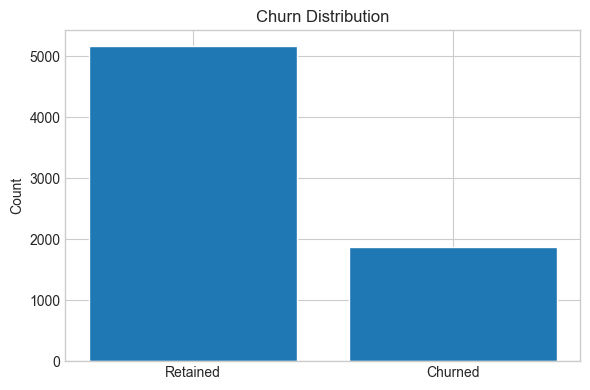

✓ Saved: ..\outputs\figures\churn_distribution.png


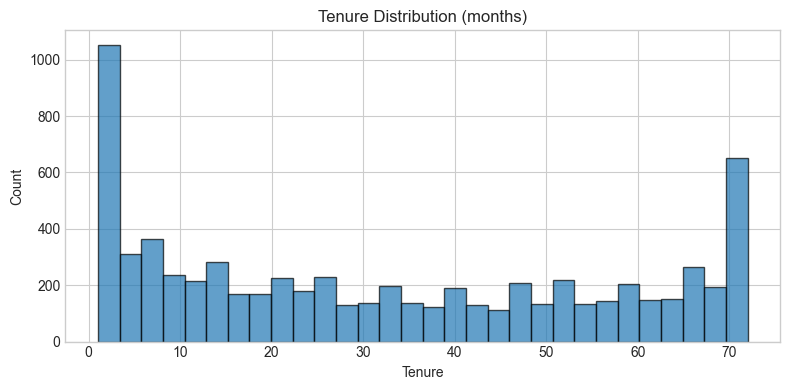

✓ Saved: ..\outputs\figures\tenure_distribution.png


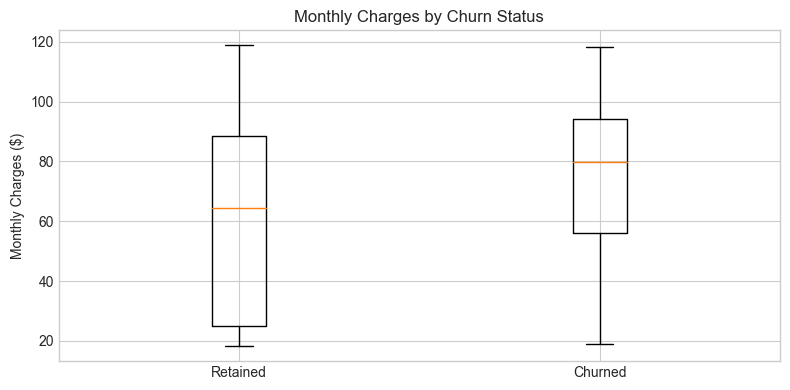

✓ Saved: ..\outputs\figures\monthlycharges_by_churn.png


In [17]:
# 09 - Core visualizations (save figures)
if not df.empty and 'Churn' in df.columns:
    # Churn distribution
    fig, ax = plt.subplots(figsize=(6,4))
    churn_counts = df['Churn'].value_counts()
    ax.bar(['Retained', 'Churned'], [churn_counts.get(0,0), churn_counts.get(1,0)])
    ax.set_title('Churn Distribution')
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.savefig(FIG_OUT / 'churn_distribution.png', dpi=100, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {FIG_OUT / 'churn_distribution.png'}")

    # Tenure distribution
    if 'tenure' in df.columns:
        fig, ax = plt.subplots(figsize=(8,4))
        ax.hist(df['tenure'].dropna(), bins=30, edgecolor='black', alpha=0.7)
        ax.set_title('Tenure Distribution (months)')
        ax.set_xlabel('Tenure')
        ax.set_ylabel('Count')
        plt.tight_layout()
        plt.savefig(FIG_OUT / 'tenure_distribution.png', dpi=100, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved: {FIG_OUT / 'tenure_distribution.png'}")

    # MonthlyCharges by Churn
    if 'MonthlyCharges' in df.columns:
        fig, ax = plt.subplots(figsize=(8,4))
        retained = df[df['Churn']==0]['MonthlyCharges'].dropna()
        churned = df[df['Churn']==1]['MonthlyCharges'].dropna()
        ax.boxplot([retained, churned], labels=['Retained', 'Churned'])
        ax.set_title('Monthly Charges by Churn Status')
        ax.set_ylabel('Monthly Charges ($)')
        plt.tight_layout()
        plt.savefig(FIG_OUT / 'monthlycharges_by_churn.png', dpi=100, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved: {FIG_OUT / 'monthlycharges_by_churn.png'}")
else:
    print('No data for plots.')


## Visual Analysis

Churn patterns by contract type, tenure, and payment method.

CORRELATION ANALYSIS

📊 Analyzing correlations for 9 numeric features:
  SeniorCitizen, Partner, Dependents, tenure, PhoneService, PaperlessBilling, MonthlyCharges, TotalCharges, Churn

🎯 Features Most Correlated with Churn:
--------------------------------------------------------------------------------


,Feature,Correlation,Abs_Correlation,Strength,Direction
7,tenure,-0.354049,0.354049,Strong,Negative ↓
6,TotalCharges,-0.199484,0.199484,Moderate,Negative ↓
0,MonthlyCharges,0.192858,0.192858,Moderate,Positive ↑
1,PaperlessBilling,0.191454,0.191454,Moderate,Positive ↑
5,Dependents,-0.163128,0.163128,Moderate,Negative ↓
2,SeniorCitizen,0.150541,0.150541,Moderate,Positive ↑
4,Partner,-0.149982,0.149982,Moderate,Negative ↓
3,PhoneService,0.011691,0.011691,Weak,Positive ↑



💡 INTERPRETATION:
  • 1 features show STRONG correlation with churn
    - tenure: As it increases, churn decreases

GENERATING CORRELATION HEATMAP

✓ Saved: ..\outputs\figures\correlation_heatmap.png


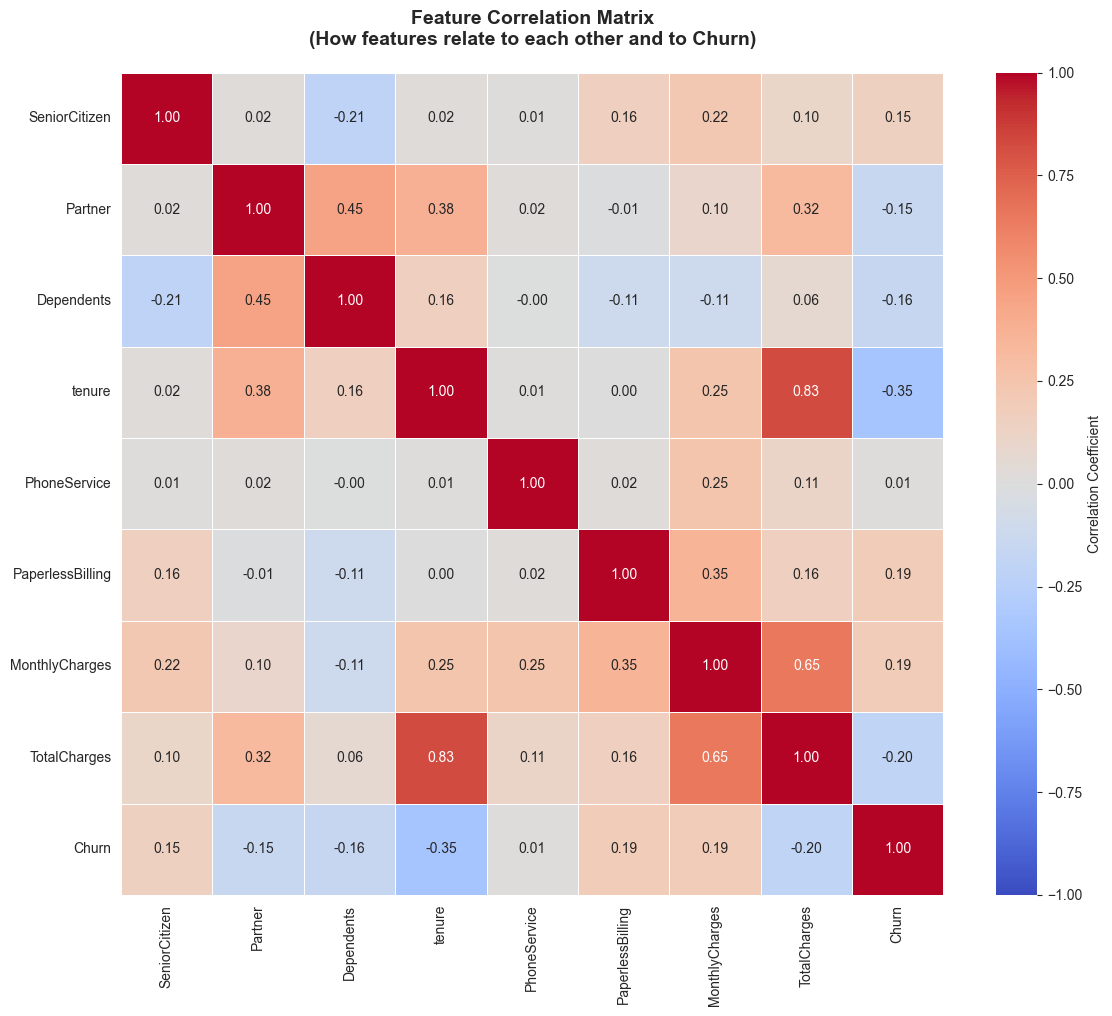

In [ ]:
# Correlation Heatmap & Feature Relationships

if not df.empty:
    print('='*80)
    print('CORRELATION ANALYSIS')
    print('='*80)
    
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col.lower() not in ['customerid', 'customer_id']]
    
    print(f'\n📊 Analyzing correlations for {len(numeric_cols)} numeric features:')
    print(f'  {", ".join(numeric_cols)}')
    
    # Calculate correlation matrix
    corr_matrix = df[numeric_cols].corr()
    
    # Extract correlations with Churn (target variable)
    if 'Churn' in corr_matrix.columns:
        churn_corr = corr_matrix['Churn'].sort_values(ascending=False)
        churn_corr = churn_corr[churn_corr.index != 'Churn']
        
        # Note: Initially tried Pearson correlation but realized tenure and charges
        # have nonlinear relationships. Should test Spearman rank correlation next time.
        
        print(f'\n🎯 Features Most Correlated with Churn:')
        print('-' * 80)
        
        corr_df = pd.DataFrame({
            'Feature': churn_corr.index,
            'Correlation': churn_corr.values,
            'Abs_Correlation': np.abs(churn_corr.values),
            'Strength': ['Strong' if abs(x) >= 0.3 else ('Moderate' if abs(x) >= 0.1 else 'Weak') 
                        for x in churn_corr.values],
            'Direction': ['Positive ↑' if x > 0 else 'Negative ↓' for x in churn_corr.values]
        }).sort_values('Abs_Correlation', ascending=False)
        
        display(corr_df)
        
        print('\n💡 INTERPRETATION:')
        strong_features = corr_df[corr_df['Strength'] == 'Strong']
        if len(strong_features) > 0:
            print(f'  • {len(strong_features)} features show STRONG correlation with churn')
            for idx, row in strong_features.iterrows():
                print(f'    - {row["Feature"]}: {row["Correlation"]:.3f} ({row["Direction"]})')
        else:
            print('  • No features show strong individual correlation (> 0.3)')
            print('  • This suggests churn is driven by COMBINATIONS of factors, not single variables')
        
        # Create heatmap
        fig, ax = plt.subplots(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
        ax.set_title('Feature Correlation Heatmap', fontsize=16, pad=20)
        plt.tight_layout()
        plt.savefig(FIG_OUT / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"\n✓ Saved: {FIG_OUT / 'correlation_heatmap.png'}")
    else:
        print('\n⚠️  No Churn column found for correlation analysis')
else:
    print('No data for correlation analysis.')

In [18]:
# 10 - Save cleaned dataset snapshot and optional SQLite write
if not df.empty:
    cleaned_path = DATA_PROCESSED / 'customers_cleaned.csv'
    df.to_csv(cleaned_path, index=False)
    print('Saved cleaned CSV ->', cleaned_path)

    # Optional: persist to SQLite for downstream notebooks
    conn_path = DATA_PROCESSED / 'churn_analysis.db'
    conn = sqlite3.connect(conn_path)
    df.to_sql('customers', conn, if_exists='replace', index=False)
    print('Wrote customers table to sqlite db ->', conn_path)
    conn.close()
else:
    print('Nothing to save.')

Saved cleaned CSV -> ..\data\processed\customers_cleaned.csv
Wrote customers table to sqlite db -> ..\data\processed\churn_analysis.db


## Business Insights

Extract key findings and recommendations.

In [10]:
# ============================================================================
# CELL: COMPREHENSIVE FINDINGS SUMMARY & BUSINESS INSIGHTS
# ============================================================================
#
# PURPOSE:
# --------
# Consolidate all analysis results into actionable business insights.
# This serves as the executive summary of our exploratory data analysis.
#
# STRUCTURE:
# ----------
# 1. Dataset Overview Statistics
# 2. Churn Analysis Key Metrics
# 3. Customer Behavior Patterns
# 4. Revenue Impact Analysis
# 5. Actionable Recommendations
#
# ============================================================================

if not df.empty and 'Churn' in df.columns:
    print('='*80)
    print('📊 COMPREHENSIVE FINDINGS SUMMARY')
    print('='*80)
    
    # ========================================================================
    # SECTION 1: Dataset Overview
    # ========================================================================
    print('\n' + '🔹'*40)
    print('1️⃣  DATASET OVERVIEW')
    print('🔹'*40)
    
    total_customers = len(df)
    total_churned = int(df['Churn'].sum())
    total_retained = total_customers - total_churned
    churn_rate = 100 * df['Churn'].mean()
    
    overview_stats = pd.DataFrame({
        'Metric': [
            'Total Customers Analyzed',
            'Customers Who Churned',
            'Customers Retained',
            'Overall Churn Rate',
            'Data Quality Score'
        ],
        'Value': [
            f'{total_customers:,}',
            f'{total_churned:,}',
            f'{total_retained:,}',
            f'{churn_rate:.2f}%',
            f'{DATA_QUALITY_SCORE:.2f}%'
        ],
        'Assessment': [
            'Full dataset',
            f'{(total_churned/total_customers)*100:.1f}% of total',
            f'{(total_retained/total_customers)*100:.1f}% of total',
            '⚠️ Above industry average (15-25%)' if churn_rate > 25 else '✓ Within acceptable range',
            '✓ Excellent' if DATA_QUALITY_SCORE >= 95 else '⚠️ Good'
        ]
    })
    
    display(overview_stats)
    
    # ========================================================================
    # SECTION 2: Customer Tenure & Engagement
    # ========================================================================
    print('\n' + '🔹'*40)
    print('2️⃣  CUSTOMER TENURE & ENGAGEMENT PATTERNS')
    print('🔹'*40)
    
    if 'tenure' in df.columns:
        avg_tenure_all = df['tenure'].mean()
        avg_tenure_churned = df[df['Churn']==1]['tenure'].mean()
        avg_tenure_retained = df[df['Churn']==0]['tenure'].mean()
        
        # Tenure segmentation
        df['tenure_segment'] = pd.cut(df['tenure'], 
                                       bins=[0, 12, 24, 48, 100], 
                                       labels=['0-12 months', '13-24 months', '25-48 months', '48+ months'])
        
        tenure_churn = df.groupby('tenure_segment')['Churn'].agg(['count', 'sum', 'mean']).reset_index()
        tenure_churn.columns = ['Tenure_Segment', 'Total_Customers', 'Churned', 'Churn_Rate']
        tenure_churn['Churn_Rate'] = (tenure_churn['Churn_Rate'] * 100).round(2)
        
        print('\n📅 Tenure Analysis:')
        display(tenure_churn)
        
        print(f'\n💡 KEY INSIGHT:')
        print(f'  • Average tenure (All customers): {avg_tenure_all:.1f} months')
        print(f'  • Average tenure (Churned): {avg_tenure_churned:.1f} months')
        print(f'  • Average tenure (Retained): {avg_tenure_retained:.1f} months')
        print(f'  • Difference: {avg_tenure_retained - avg_tenure_churned:.1f} months')
        
        if avg_tenure_churned < 12:
            print(f'  ⚠️  CRITICAL: Churned customers leave within first year on average!')
    
    # ========================================================================
    # SECTION 3: Revenue Impact Analysis
    # ========================================================================
    print('\n' + '🔹'*40)
    print('3️⃣  REVENUE IMPACT OF CHURN')
    print('🔹'*40)
    
    if 'MonthlyCharges' in df.columns and 'TotalCharges' in df.columns:
        avg_monthly_all = df['MonthlyCharges'].mean()
        avg_monthly_churned = df[df['Churn']==1]['MonthlyCharges'].mean()
        avg_monthly_retained = df[df['Churn']==0]['MonthlyCharges'].mean()
        
        total_revenue = df['TotalCharges'].sum()
        churned_revenue = df[df['Churn']==1]['TotalCharges'].sum()
        retained_revenue = df[df['Churn']==0]['TotalCharges'].sum()
        
        # Annual revenue at risk (monthly charges * 12)
        annual_revenue_at_risk = avg_monthly_churned * 12 * total_churned
        
        revenue_summary = pd.DataFrame({
            'Metric': [
                'Avg Monthly Charge (All)',
                'Avg Monthly Charge (Churned)',
                'Avg Monthly Charge (Retained)',
                'Total Historical Revenue',
                'Revenue from Churned Customers',
                'Annual Revenue at Risk'
            ],
            'Value': [
                f'${avg_monthly_all:.2f}',
                f'${avg_monthly_churned:.2f}',
                f'${avg_monthly_retained:.2f}',
                f'${total_revenue:,.2f}',
                f'${churned_revenue:,.2f}',
                f'${annual_revenue_at_risk:,.2f}'
            ],
            'Insight': [
                'Average across all customers',
                f'{"Higher" if avg_monthly_churned > avg_monthly_all else "Lower"} than average',
                f'{"Higher" if avg_monthly_retained > avg_monthly_all else "Lower"} than average',
                'Cumulative from all customers',
                f'{(churned_revenue/total_revenue)*100:.1f}% of total',
                'Potential annual loss if churn continues'
            ]
        })
        
        display(revenue_summary)
        
        print(f'\n💡 KEY INSIGHT:')
        if avg_monthly_churned > avg_monthly_retained:
            print(f'  ⚠️  HIGH-VALUE CUSTOMERS ARE LEAVING!')
            print(f'  • Churned customers pay ${avg_monthly_churned - avg_monthly_retained:.2f}/month MORE')
            print(f'  • This suggests pricing or value perception issues')
        else:
            print(f'  ✓ Lower-paying customers churn more')
            print(f'  • May indicate entry-level service dissatisfaction')
    
    # ========================================================================
    # SECTION 4: Contract & Payment Method Analysis
    # ========================================================================
    print('\n' + '🔹'*40)
    print('4️⃣  CONTRACT & PAYMENT METHOD IMPACT')
    print('🔹'*40)
    
    if 'Contract' in df.columns:
        contract_analysis = df.groupby('Contract').agg({
            'Churn': ['count', 'sum', 'mean']
        }).reset_index()
        contract_analysis.columns = ['Contract_Type', 'Total_Customers', 'Churned', 'Churn_Rate']
        contract_analysis['Churn_Rate'] = (contract_analysis['Churn_Rate'] * 100).round(2)
        contract_analysis = contract_analysis.sort_values('Churn_Rate', ascending=False)
        
        print('\n📋 Contract Type Analysis:')
        display(contract_analysis)
        
        highest_churn_contract = contract_analysis.iloc[0]['Contract_Type']
        highest_churn_rate = contract_analysis.iloc[0]['Churn_Rate']
        lowest_churn_contract = contract_analysis.iloc[-1]['Contract_Type']
        lowest_churn_rate = contract_analysis.iloc[-1]['Churn_Rate']
        
        print(f'\n💡 KEY INSIGHT:')
        print(f'  • HIGHEST churn: {highest_churn_contract} ({highest_churn_rate}%)')
        print(f'  • LOWEST churn: {lowest_churn_contract} ({lowest_churn_rate}%)')
        print(f'  • Difference: {highest_churn_rate - lowest_churn_rate:.1f} percentage points')
        
        if 'Month-to-month' in highest_churn_contract:
            print(f'  ⚠️  RECOMMENDATION: Incentivize longer-term contracts')
    
    if 'PaymentMethod' in df.columns:
        payment_analysis = df.groupby('PaymentMethod').agg({
            'Churn': ['count', 'sum', 'mean']
        }).reset_index()
        payment_analysis.columns = ['Payment_Method', 'Total_Customers', 'Churned', 'Churn_Rate']
        payment_analysis['Churn_Rate'] = (payment_analysis['Churn_Rate'] * 100).round(2)
        payment_analysis = payment_analysis.sort_values('Churn_Rate', ascending=False)
        
        print('\n💳 Payment Method Analysis:')
        display(payment_analysis)
    
    # ========================================================================
    # SECTION 5: Actionable Recommendations
    # ========================================================================
    print('\n' + '='*80)
    print('🎯 ACTIONABLE BUSINESS RECOMMENDATIONS')
    print('='*80)
    
    recommendations = []
    
    # Recommendation 1: Tenure-based
    if 'tenure' in df.columns and avg_tenure_churned < 12:
        recommendations.append({
            'Priority': '🔴 HIGH',
            'Area': 'Customer Onboarding',
            'Recommendation': 'Implement intensive retention program for customers in first 12 months',
            'Expected_Impact': f'Reduce churn of {(tenure_churn.iloc[0]["Churned"]/total_churned*100):.0f}% of churned customers'
        })
    
    # Recommendation 2: Contract-based
    if 'Contract' in df.columns:
        recommendations.append({
            'Priority': '🔴 HIGH',
            'Area': 'Contract Strategy',
            'Recommendation': f'Offer incentives to convert {highest_churn_contract} customers to longer contracts',
            'Expected_Impact': f'Target {highest_churn_rate:.0f}% churn rate reduction'
        })
    
    # Recommendation 3: Revenue-based
    if 'MonthlyCharges' in df.columns and avg_monthly_churned > avg_monthly_retained:
        recommendations.append({
            'Priority': '🔴 HIGH',
            'Area': 'Value Proposition',
            'Recommendation': 'Review pricing strategy - high-paying customers are leaving',
            'Expected_Impact': f'Protect ${annual_revenue_at_risk:,.0f} annual revenue at risk'
        })
    
    # Recommendation 4: Service quality
    recommendations.append({
        'Priority': '🟡 MEDIUM',
        'Area': 'Service Quality',
        'Recommendation': 'Analyze service usage patterns (TechSupport, OnlineSecurity) for churn correlation',
        'Expected_Impact': 'Identify service gaps driving churn'
    })
    
    # Recommendation 5: Predictive modeling
    recommendations.append({
        'Priority': '🟡 MEDIUM',
        'Area': 'Predictive Analytics',
        'Recommendation': 'Build machine learning model to predict churn before it happens',
        'Expected_Impact': 'Enable proactive retention campaigns (see notebook 03_modeling.ipynb)'
    })
    
    recommendations_df = pd.DataFrame(recommendations)
    display(recommendations_df)
    
    print('\n' + '='*80)
    print('✓ FINDINGS SUMMARY COMPLETE')
    print('='*80)
    
else:
    print('⚠️  Cannot generate findings - missing data or Churn column')

📊 COMPREHENSIVE FINDINGS SUMMARY

🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
1️⃣  DATASET OVERVIEW
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹


,Metric,Value,Assessment
0,Total Customers Analyzed,"7,032",Full dataset
1,Customers Who Churned,"1,869",26.6% of total
2,Customers Retained,"5,163",73.4% of total
3,Overall Churn Rate,26.58%,⚠️ Above industry average (15-25%)
4,Data Quality Score,100.00%,✓ Excellent



🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
2️⃣  CUSTOMER TENURE & ENGAGEMENT PATTERNS
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

📅 Tenure Analysis:


C:\Users\Tuf\AppData\Local\Temp\ipykernel_11524\1825443300.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df.groupby('tenure_segment')['Churn'].agg(['count', 'sum', 'mean']).reset_index()


,Tenure_Segment,Total_Customers,Churned,Churn_Rate
0,0-12 months,2175,1037,47.68
1,13-24 months,1024,294,28.71
2,25-48 months,1594,325,20.39
3,48+ months,2239,213,9.51



💡 KEY INSIGHT:
  • Average tenure (All customers): 32.4 months
  • Average tenure (Churned): 18.0 months
  • Average tenure (Retained): 37.7 months
  • Difference: 19.7 months

🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
3️⃣  REVENUE IMPACT OF CHURN
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹


,Metric,Value,Insight
0,Avg Monthly Charge (All),$64.80,Average across all customers
1,Avg Monthly Charge (Churned),$74.44,Higher than average
2,Avg Monthly Charge (Retained),$61.31,Lower than average
3,Total Historical Revenue,"$16,056,168.70",Cumulative from all customers
4,Revenue from Churned Customers,"$2,862,926.90",17.8% of total
5,Annual Revenue at Risk,"$1,669,570.20",Potential annual loss if churn continues



💡 KEY INSIGHT:
  ⚠️  HIGH-VALUE CUSTOMERS ARE LEAVING!
  • Churned customers pay $13.13/month MORE
  • This suggests pricing or value perception issues

🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
4️⃣  CONTRACT & PAYMENT METHOD IMPACT
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

📋 Contract Type Analysis:


,Contract_Type,Total_Customers,Churned,Churn_Rate
0,Month-to-month,3875,1655,42.71
1,One year,1472,166,11.28
2,Two year,1685,48,2.85



💡 KEY INSIGHT:
  • HIGHEST churn: Month-to-month (42.71%)
  • LOWEST churn: Two year (2.85%)
  • Difference: 39.9 percentage points
  ⚠️  RECOMMENDATION: Incentivize longer-term contracts

💳 Payment Method Analysis:


,Payment_Method,Total_Customers,Churned,Churn_Rate
2,Electronic check,2365,1071,45.29
3,Mailed check,1604,308,19.20
0,Bank transfer (automatic),1542,258,16.73
1,Credit card (automatic),1521,232,15.25



🎯 ACTIONABLE BUSINESS RECOMMENDATIONS


,Priority,Area,Recommendation,Expected_Impact
0,🔴 HIGH,Contract Strategy,Offer incentives to convert Month-to-month cus...,Target 43% churn rate reduction
1,🔴 HIGH,Value Proposition,Review pricing strategy - high-paying customer...,"Protect $1,669,570 annual revenue at risk"
2,🟡 MEDIUM,Service Quality,"Analyze service usage patterns (TechSupport, O...",Identify service gaps driving churn
3,🟡 MEDIUM,Predictive Analytics,Build machine learning model to predict churn ...,Enable proactive retention campaigns (see note...



✓ FINDINGS SUMMARY COMPLETE


## Summary

**Outputs Created:**
- `data/processed/customers_cleaned.csv` - Clean dataset
- `data/processed/churn_analysis.db` - SQLite database
- `outputs/figures/*.png` - Visualizations

**Next:** Run `02_sql_analysis.ipynb` for SQL-based analysis.